In [2]:
import requests
import netwulf as wulf
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# См. https://netwulf.readthedocs.io/en/latest/python_api/start.html
# https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model
G = nx.barabasi_albert_graph(n=100, m=3)
visualize(G)

In [3]:
def retrieve_all_plays(corpusname):
    response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/metadata')
    response.raise_for_status()
    return [play['playName'] for play in response.json()]

In [39]:
def netwulf_representation(corpusname, playname, size='weightedDegree', group=None, show_node_labels=True, show_link_labels=False, is_test=False, extension='png'):
    """
    corpusname: 'ger'/'greek'/'rom'/'rus'/'shake'/'span'
    playname: 'pushkin-boris-godunov'/...
    size (what should we consider as the size of a node?):
    - 'numOfSpeechActs',
    - 'numOfWords' (the number of uttered words by a character),
    - 'degree' (the number of people/groups of people with whom a character appeared during the same minimal scene),
    - 'weightedDegree' (default),
    - 'numOfScenes' (the number of scenes in which a character appeared)
    group (what should we consider as group divider?):
    - 'gender' (MALE/FEMALE/UNKNOWN)
    - 'isGroup' (a group or a person)
    - None (default)
    show_node_labels (display characters' names or not): True/False (default: True)
    show_link_labels (display the weight of a link on itself): True/False (default: False)
    is_test (if `True`, the interactive environment will post its visualization to Python automatically after 5 seconds): True/False (default: False)
    extension (extension of output file): 'png'/'jpg'/'pdf'/...
    """

    # define titles for output files
    title = corpusname + '_' + playname
    json_title = '_'.join([corpusname, playname, size, str(group)])

    # define config for visualization
    config = {
        # Input/output
        'zoom': 3,
        # Nodes
        'node_fill_color': '#1cf2c7',
        'display_node_labels': True,
        'node_size': 4,
        # Links
        'link_color': '#ff7500',
        'link_width': 0.7,
        'link_width_variation': 1,
    }

    try:
        # if there is a corresponding json file
        network, config, _ = wulf.load(f"{json_title}.json")
        # use nodes and links from the network
        nodes = network['nodes']
        links = network['links']
        network, config = wulf.visualize(network, config=config, is_test=is_test, verbose=False, plot_in_cell_below=False)
    except FileNotFoundError:
        # if there is no corresponding json file
        # make a request
        nodes_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/cast')
        nodes_response.raise_for_status()
        # list of dicts with node's labels and sizes
        nodes = [{'id': character['id'], 'size': character[size]} for character in nodes_response.json()]
        # add 'group' attribute to the nodes if group is not None
        if group is not None:
            nodes = [dict(node, **{'group': character[group]}) for node, character in zip(nodes, nodes_response.json())]
        # make a request for links
        links_response = requests.get(f'https://dracor.org/api/corpora/{corpusname}/play/{playname}/networkdata/csv')
        links_response.raise_for_status()
        # list of dicts with link's sources, targets and weights
        links = []
        for link in links_response.text.split('\n')[1:]:  # skip header
            source, _, target, weight = link.split(',')
            links.append({'source': source, 'target': target, 'weight': int(float(weight))})
            # visualize a network and save the appropriate settings
        network, config = wulf.visualize({'nodes': nodes, 'links': links}, config=config, is_test=is_test, verbose=False, plot_in_cell_below=False)

    fig, ax = wulf.draw_netwulf(network, figsize=24)
    # add node labels if necessary
    if show_node_labels:
        for node in nodes:
            wulf.add_node_label(ax, network, node['id'], label=node['id'], size=20)
    # add link labels if necessary
    if show_link_labels:
        for link in links:
            wulf.add_edge_label(ax, network, (link['source'], link['target']), link['weight'], size=20)
    # add title
    ax.set_title(title, size=24)
    plt.subplots_adjust(top=0.88)
    # save picture
    plt.savefig(f'{title}.{extension}', bbox_inches='tight')
    # and display here
    plt.show()
    # save network and config to json file
    wulf.save(f'{json_title}.json', network, config)

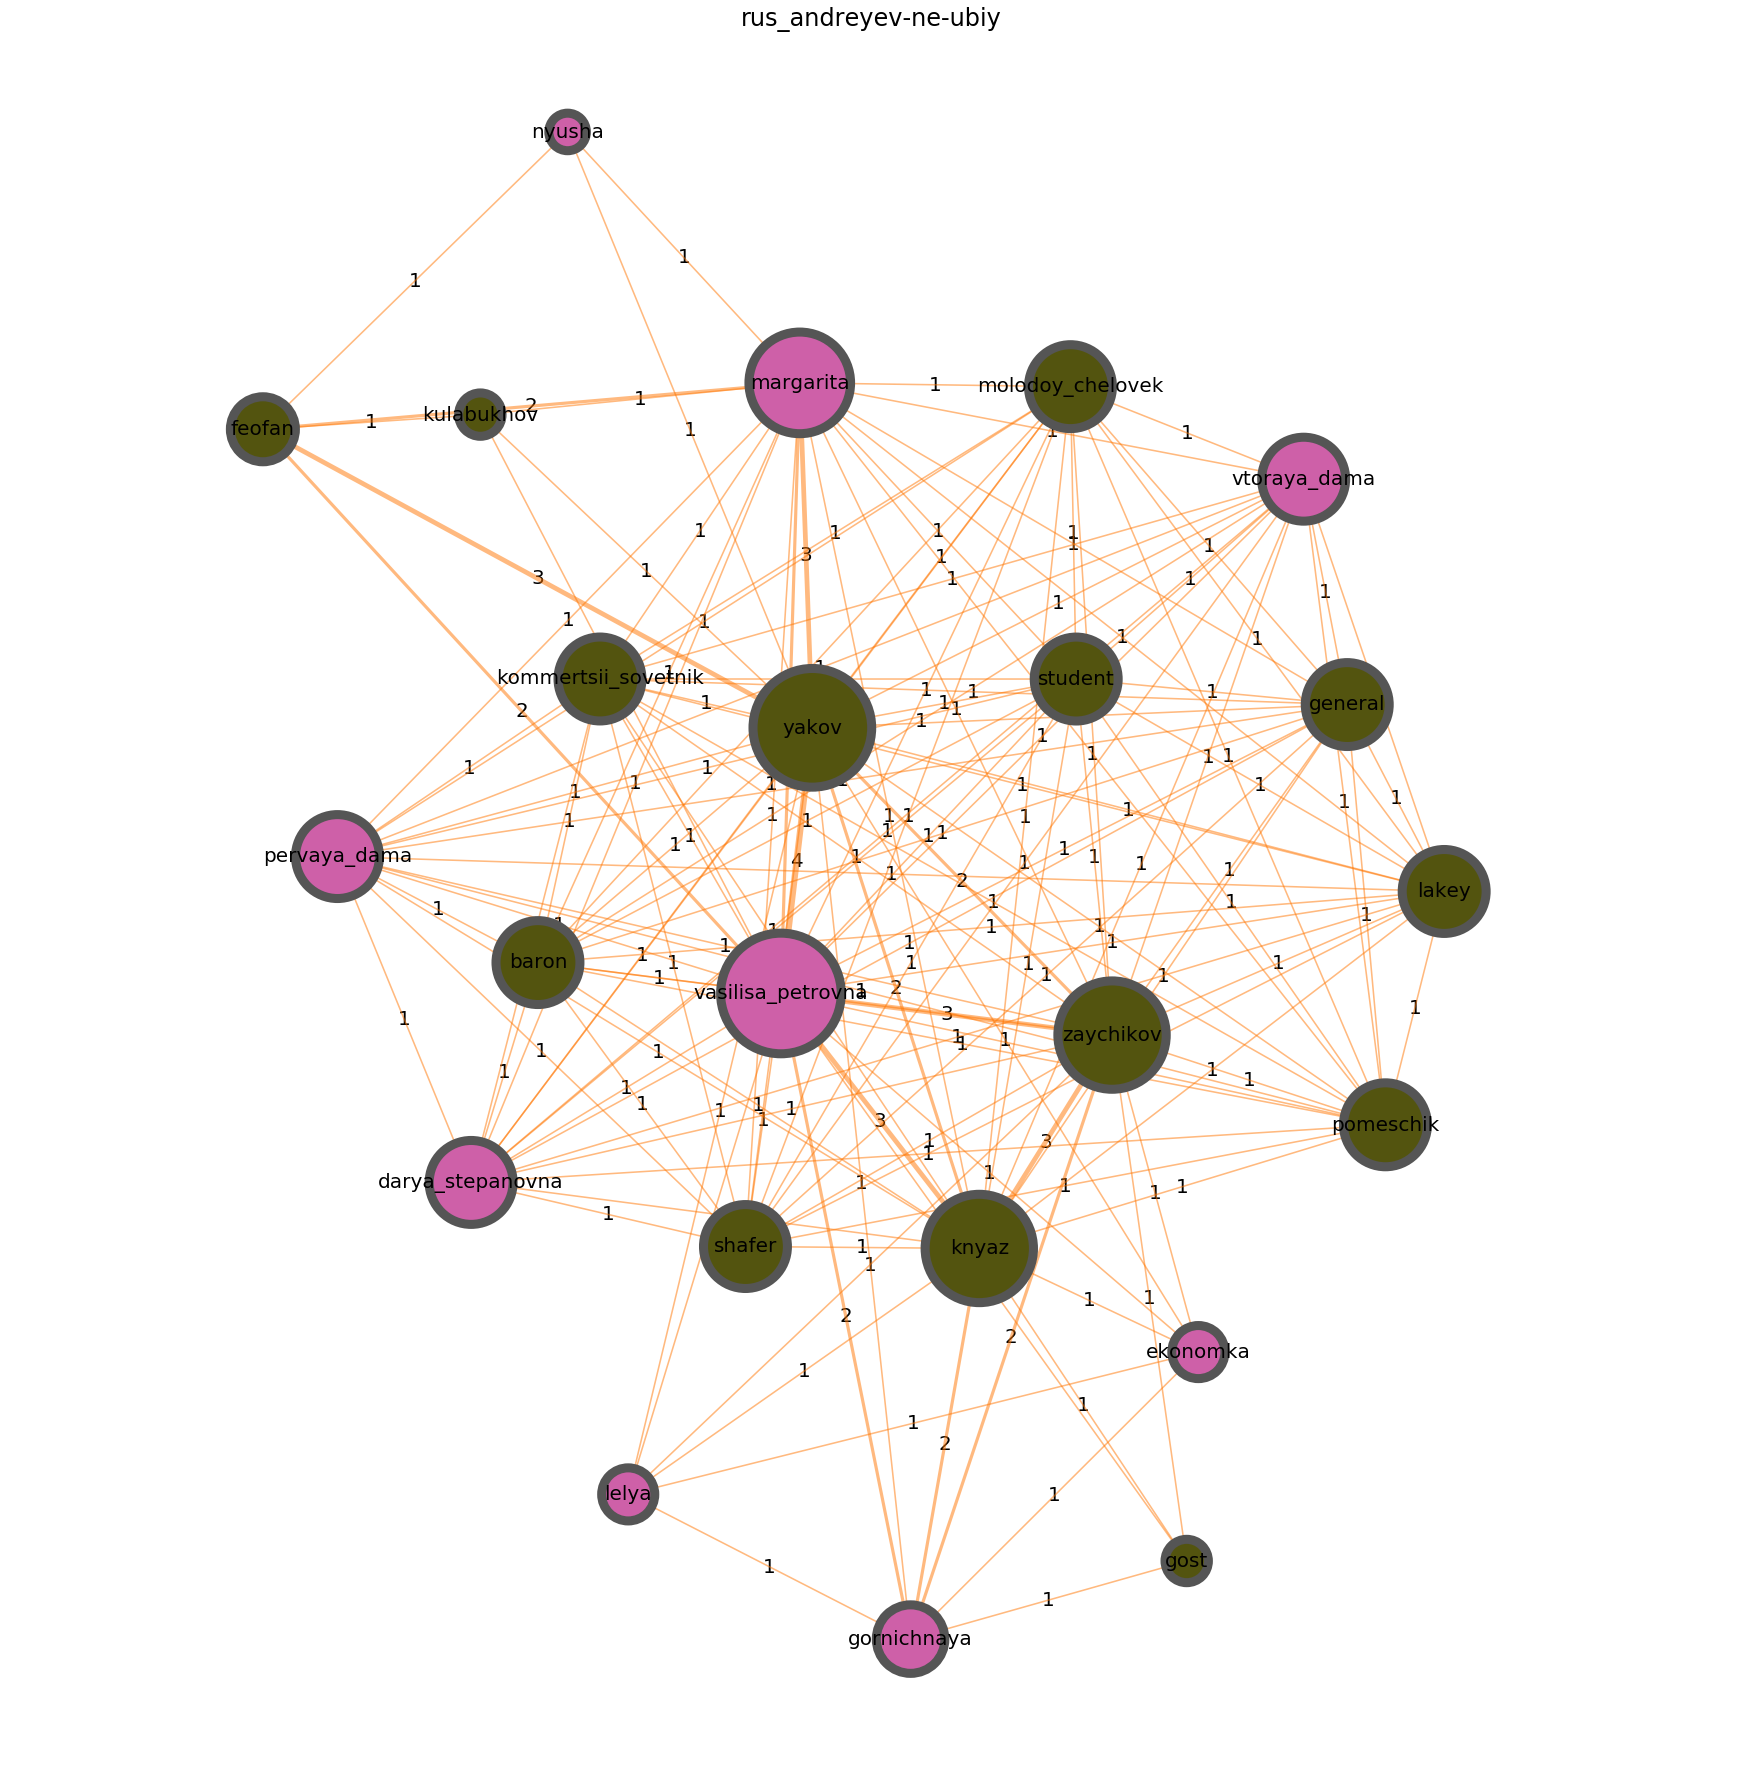

In [42]:
netwulf_representation('rus', 'andreyev-ne-ubiy', group='gender', show_link_labels=True)

In [ ]:
netwulf_representation('rus', 'pushkin-boris-godunov', group='gender', size='numOfSpeechActs', show_node_labels=False)

In [141]:
playnames = retrieve_all_plays('rus')

In [ ]:
for playname in playnames:
    netwulf_representation('rus', playname, size='weightedDegree', group='gender', show_link_labels=True, is_test=True)